In [1]:
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import KeyedVectors
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [2]:
#LIRE LE DATASET

train = pd.read_csv('Dataset/training.csv')
test = pd.read_csv('Dataset/test.csv')
validate = pd.read_csv('Dataset/validation.csv')

print("Test Dataset Lu")


#PRETRAITEMENT DU DATASET

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
valid_labels = [0, 1, 2, 3, 4]  


train = train[train['label'].isin(valid_labels)]
test = test[test['label'].isin(valid_labels)]
validate = validate[validate['label'].isin(valid_labels)]

def nettoyer(text):
    text = text.lower()
    # Supprimer les caractères spéciaux
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenisation
    words = nltk.word_tokenize(text)
    # Suppression des mots vides et lemmatisation
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Reconstituer le texte prétraité
    return words

test['text'] = test['text'].apply(nettoyer).tolist()
train['text'] = train['text'].apply(nettoyer).tolist()
validate['text'] = validate['text'].apply(nettoyer).tolist()

# Vérification
print("Corpus après prétraitement :\n", test[:5])
print("Corpus après prétraitement :\n", train[:5])


Test Dataset Lu
Corpus après prétraitement :
                                                 text  label
0  [im, feeling, rather, rotten, im, ambitious, r...      0
1                 [im, updating, blog, feel, shitty]      0
2  [never, make, separate, ever, want, feel, like...      0
3  [left, bouquet, red, yellow, tulip, arm, feeli...      1
4                       [feeling, little, vain, one]      0
Corpus après prétraitement :
                                                 text  label
0                          [didnt, feel, humiliated]      0
1  [go, feeling, hopeless, damned, hopeful, aroun...      0
2  [im, grabbing, minute, post, feel, greedy, wrong]      3
3  [ever, feeling, nostalgic, fireplace, know, st...      2
4                                 [feeling, grouchy]      3


Vectorisation Word2Vec

In [3]:
word2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

def words_to_embedding_sequence(words, model, max_sequence_length):
    embeddings = [model[word] if word in model else np.zeros(model.vector_size) for word in words]
    while len(embeddings) < max_sequence_length:
        embeddings.append(np.zeros(model.vector_size))
    return embeddings[:max_sequence_length]

def process_dataset(dataset, column, model, max_sequence_length):
    return np.array([words_to_embedding_sequence(words, model, max_sequence_length) for words in dataset[column]])

max_sequence_length = 66
x_train = process_dataset(train, 'text', word2vec_model , max_sequence_length)
x_test = process_dataset(test, 'text', word2vec_model, max_sequence_length)
x_validate = process_dataset(validate, 'text',word2vec_model, max_sequence_length)

# Convertir les labels en one-hot encoding
y_train = to_categorical(train['label'], num_classes=5)
y_test = to_categorical(test['label'], num_classes=5)
y_validate = to_categorical(validate['label'], num_classes=5)


print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", x_validate.shape)
print("y_val shape:", y_validate.shape)



X_train shape: (15428, 66, 300)
y_train shape: (15428, 5)
X_test shape: (1934, 66, 300)
y_test shape: (1934, 5)
X_val shape: (1919, 66, 300)
y_val shape: (1919, 5)


Vectorisation GLOVE

In [4]:
# Charger les embeddings GloVe
def load_glove_embeddings(file_path, vector_size=300):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

glove_file = "glove.6B/glove.6B.300d.txt"  # Chemin vers le fichier GloVe
glove_embeddings = load_glove_embeddings(glove_file)

# Transformer les mots en séquences d'embeddings avec padding
def words_to_embedding_sequence(words, embeddings, max_sequence_length):
    vectors = [embeddings[word] if word in embeddings else np.zeros(len(next(iter(embeddings.values())))) for word in words]
    while len(vectors) < max_sequence_length:
        vectors.append(np.zeros(len(next(iter(embeddings.values())))))
    return vectors[:max_sequence_length]

# Traiter le dataset pour obtenir des séquences d'embeddings
def process_dataset(dataset, column, embeddings, max_sequence_length):
    return np.array([words_to_embedding_sequence(words, embeddings, max_sequence_length) for words in dataset[column]])

# Paramètres
max_sequence_length = 66
vector_size = 300  # Taille des vecteurs dans GloVe (par exemple, 300 pour glove.6B.300d.txt)

# Appliquer aux datasets
x_train = process_dataset(train, 'text', glove_embeddings, max_sequence_length)
x_test = process_dataset(test, 'text', glove_embeddings, max_sequence_length)
x_validate = process_dataset(validate, 'text', glove_embeddings, max_sequence_length)

# Convertir les labels en one-hot encoding
y_train = to_categorical(train['label'], num_classes=5)
y_test = to_categorical(test['label'], num_classes=5)
y_validate = to_categorical(validate['label'], num_classes=5)

# Afficher les formes des données
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", x_validate.shape)
print("y_val shape:", y_validate.shape)


X_train shape: (15428, 66, 300)
y_train shape: (15428, 5)
X_test shape: (1934, 66, 300)
y_test shape: (1934, 5)
X_val shape: (1919, 66, 300)
y_val shape: (1919, 5)


Vectorisation FastText

In [6]:
fasttext_model_path = 'wiki-news-300d-1M.vec'
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)

def words_to_embedding_sequence(words, embeddings, max_sequence_length):
    vectors = [embeddings[word] if word in embeddings else np.zeros(embeddings.vector_size) for word in words]
    while len(vectors) < max_sequence_length:
        vectors.append(np.zeros(embeddings.vector_size))
    return vectors[:max_sequence_length]

# Traiter le dataset pour obtenir des séquences d'embeddings
def process_dataset(dataset, column, embeddings, max_sequence_length):
    return np.array([words_to_embedding_sequence(words, embeddings, max_sequence_length) for words in dataset[column]])

# Paramètres
max_sequence_length = 66
vector_size = 300  # Taille des vecteurs dans GloVe (par exemple, 300 pour glove.6B.300d.txt)

# Appliquer aux datasets
x_train = process_dataset(train, 'text', fasttext_model, max_sequence_length)
x_test = process_dataset(test, 'text', fasttext_model, max_sequence_length)
x_validate = process_dataset(validate, 'text', fasttext_model, max_sequence_length)

# Convertir les labels en one-hot encoding
y_train = to_categorical(train['label'], num_classes=5)
y_test = to_categorical(test['label'], num_classes=5)
y_validate = to_categorical(validate['label'], num_classes=5)

# Afficher les formes des données
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", x_validate.shape)
print("y_val shape:", y_validate.shape)

X_train shape: (15428, 66, 300)
y_train shape: (15428, 5)
X_test shape: (1934, 66, 300)
y_test shape: (1934, 5)
X_val shape: (1919, 66, 300)
y_val shape: (1919, 5)


Vectorisation Bert(Transformers)

In [9]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

def words_to_embedding_sequence(sentence, tokenizer, model, max_sequence_length=66, embedding_dim=300):
    encoded_input = tokenizer(sentence, truncation=True, padding='max_length', max_length=max_sequence_length, return_tensors="pt")
    input_ids = encoded_input["input_ids"]
    attention_mask = encoded_input["attention_mask"]
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
    token_embeddings = last_hidden_state[:, :max_sequence_length, :embedding_dim].squeeze(0).cpu().numpy()
    return token_embeddings

def process_dataset_with_bert(dataset, column, tokenizer, model, max_sequence_length=66, embedding_dim=300):
    return np.array([words_to_embedding_sequence(" ".join(sentence) if isinstance(sentence, list) else sentence, tokenizer, model, max_sequence_length, embedding_dim) for sentence in dataset[column]])

x_train = process_dataset_with_bert(train, 'text', tokenizer, bert_model)
x_test = process_dataset_with_bert(test, 'text', tokenizer, bert_model)
x_validate = process_dataset_with_bert(validate, 'text', tokenizer, bert_model)

print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("X_val shape:", x_validate.shape)


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ADMIN\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an adminis

X_train shape: (15428, 66, 300)
X_test shape: (1934, 66, 300)
X_val shape: (1919, 66, 300)


Creation Model LSTM

In [10]:
def create_lstm_model(input_shape, num_classes, lstm_units=128):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

input_shape = (66, 300)
num_classes = 5
lstm_model = create_lstm_model(input_shape, num_classes)
lstm_model.summary()


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │       219,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,293 (860.52 KB)

 Trainable params: 220,293 (860.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.5129 - loss: 1.2269 - val_accuracy: 0.6107 - val_loss: 1.0120
Epoch 2/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 46s 94ms/step - accuracy: 0.6094 - loss: 1.0067 - val_accuracy: 0.6352 - val_loss: 0.9625
Epoch 3/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 47s 97ms/step - accuracy: 0.6437 - loss: 0.9247 - val_accuracy: 0.6472 - val_loss: 0.9383
Epoch 4/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 45s 92ms/step - accuracy: 0.6705 - loss: 0.8523 - val_accuracy: 0.6691 - val_loss: 0.9048
Epoch 5/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 47s 98ms/step - accuracy: 0.7128 - loss: 0.7661 - val_accuracy: 0.6941 - val_loss: 0.8577
Epoch 6/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 46s 95ms/step - accuracy: 0.7493 - loss: 0.6633 - val_accuracy: 0.7196 - val_loss: 0.7883
Epoch 7/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.7947 - loss: 0.5520 - val_accuracy: 0.7259 - val_loss: 0.7689
Epoch 8/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 44s 90ms/step - accuracy: 0.8369 - loss: 0.4521 - 

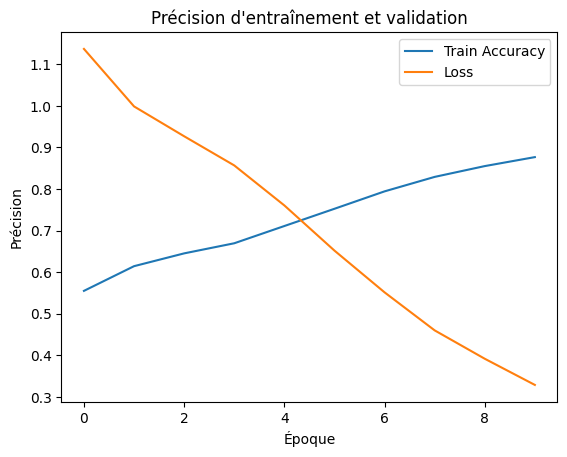

61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7461 - loss: 0.7751
Test Loss: 0.7884, Test Accuracy: 0.7441
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Accuracy: 0.7440537745604964

Classification Report:

              precision    recall  f1-score   support

     sadness       0.84      0.72      0.78       581
         joy       0.78      0.85      0.81       695
        love       0.41      0.40      0.40       159
       anger       0.64      0.72      0.68       275
        fear       0.79      0.74      0.76       224

    accuracy                           0.74      1934
   macro avg       0.69      0.69      0.69      1934
weighted avg       0.75      0.74      0.74      1934



In [11]:
# Entraînement du modèle avec validation à chaque époque
history = lstm_model.fit(
    x_train, y_train,  # Données d'entraînement
    validation_data=(x_validate, y_validate),  # Données de validation
    epochs=10,  # Nombre d'époques
    batch_size=32  # Taille des lots
)

# Visualisation de l'accuracy d'entraînement et de validation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.title('Précision d\'entraînement et validation')
plt.xlabel('Époque')
plt.ylabel('Précision')
plt.legend()
plt.show()

# Évaluation du modèle sur le jeu de test
test_loss, test_accuracy = lstm_model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Prédictions sur le jeu de test
y_pred = lstm_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcul des métriques (accuracy, précision, rappel, F1-score)
print("Accuracy:", accuracy_score(y_true, y_pred_classes))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['sadness', 'joy', 'love', 'anger', 'fear']))